<a href="https://colab.research.google.com/github/4deepprk/4deepprk.github.io/blob/master/DL109_HyperparameterTuning_MLFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Outline

1.   Basic motivation of hyperparameter tuning
2.   Integrating Google colab with a local runtime (config in Google colab, Browser, Jupyter notebook)
3.   Installing MLFlow and basic use case
4.   Logging parameters, metrics with MLFlow
5.   Logging image artifacts with MLFlow
6.   Logging PyTorch models with MLFlow and loading them



In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
from torchvision import datasets, transforms

import torch.nn as nn
import torch.optim as optim
import seaborn as sns

In [6]:
# mlflow is an open source (project - community support) platform for machine learning life cycle 
# (entire machine learning pipeline is made convenient with the help of different tools
# ie., from running the project on cloud, doing hyper-parameter tunning, etc., till the deployment)
import mlflow
import mlflow.pytorch

# Params

In [7]:
# Contains different constant parameters that we want to tune in the process of 
# hyper-parameter tunning 
class Params(object):
    def __init__(self, batch_size, epochs, seed, log_interval):
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        self.log_interval = log_interval

args = Params(256, 4, 0, 20) # batch_size, epochs, seed, log_interval

# Dataset

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
]) # single mean and single standard deviation mentioned corresponding to grey
# scale image of MNIST dataset

train_set = datasets.MNIST('../data', train=True, download=True, 
                         transform=transform)

test_set = datasets.MNIST('../data', train=False, download=True, 
                         transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=args.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=args.batch_size, shuffle=False)

100.1%

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


113.5%

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


100.4%

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


180.4%

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/home/pradeep/anaconda3/envs/mlflow_env/lib/python3.8/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629434582/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Model

In [9]:
# 784 (input neurons), 32 (first hidden layer), 10 output neurons

class Model(nn.Module):
    def __init__(self, nH = 32): 
        super(Model, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, nH),  # 28 x 28 = 784
            nn.ReLU(),
            nn.Linear(nH, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [10]:
def train(epoch):
    
    model.train()
    
    for batch_id, data in enumerate(train_loader):
        inputs, labels = data
        
        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        # Many logs per batch in training mode
        if batch_id % args.log_interval == 0:
            pos = epoch * len(train_loader) + batch_id
            # mlflow logs the loss for each image
            mlflow.log_metric('train_loss', loss.data.item()/len(inputs)*1000)
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.3f}'.format(
                epoch, batch_id * len(inputs), len(train_loader.dataset),
                100. * batch_id / len(train_loader), loss.data.item()))

In [11]:
def test(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    confusion_matrix = np.zeros([10, 10])
    
    with torch.no_grad():
        
        for inputs, labels in test_loader:
            outputs = model(inputs)
            test_loss += loss_fn(outputs, labels).data.item()
            pred = outputs.data.max(1)[1]
            correct += pred.eq(labels.data).sum().item()
            
            # predicted value (x axis) and labels or ground truth (y axis) are zipped as tuple
            for x, y in zip(pred.numpy(), labels.numpy()):
                confusion_matrix[x][y] += 1
            
        test_loss /= len(test_loader.dataset) # loss for entire test dataset
        test_accuracy = 100.0 * correct / len(test_loader.dataset)
        
        pos = (epoch + 1) * len(train_loader)
        # mlflow logs test loss and test accuracy (logging the metrics)
        # logs at the end of the batch
        mlflow.log_metric('test_loss', test_loss*1000)
        mlflow.log_metric('test_accuracy', test_accuracy)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, len(test_loader.dataset), test_accuracy))
              
        if epoch == args.epochs:
            classes = np.arange(10)
            fig, ax = plt.subplots()
            # image show (plots the confusion matrix)
            im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
            ax.figure.colorbar(im, ax=ax)
            ax.set(xticks=np.arange(confusion_matrix.shape[1]),
                       yticks=np.arange(confusion_matrix.shape[0]),
                       xticklabels=classes, yticklabels=classes,
                       ylabel='True label',
                       xlabel='Predicted label',
                       title='Epoch %d' % epoch)
            thresh = confusion_matrix.max() / 2.
            # placing the numbers in each colored cell of the confusion matrix
            for i in range(confusion_matrix.shape[0]):
                for j in range(confusion_matrix.shape[1]):
                    ax.text(j, i, int(confusion_matrix[i, j]),
                            ha="center", va="center",
                            color="white" if confusion_matrix[i, j] > thresh else "black")
                            # white text or number in dark background and black on light 
                            # background of the cell
              
            fig.tight_layout()
              
            image_path = 'images/%s.png' % (expt_id)
            plt.savefig(image_path) # save the plot directly in the location
            mlflow.log_artifact(image_path) # also saved as artifacts
            

# Hyperparameter tuning loop


LR = 0.01, Momentum = 0.90, Hidden nodes = 48

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.372
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.981
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.619
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.390
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.328
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.332
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.405
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.318
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.256
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.228
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.322
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.355

Test set: Average loss: 0.0010, Accuracy: 9259/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.264
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.263
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.210
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.357
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.263
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.333
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.258
Train Epoch:

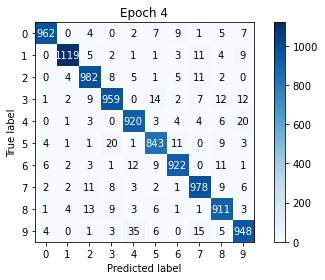

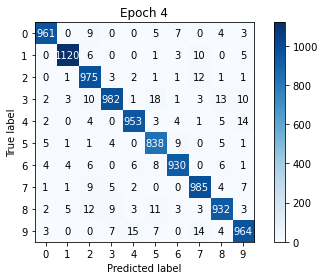

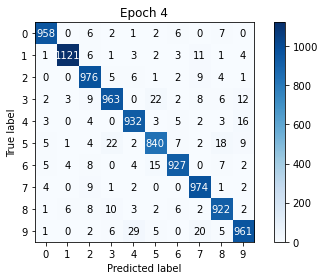

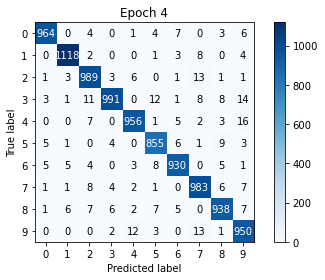

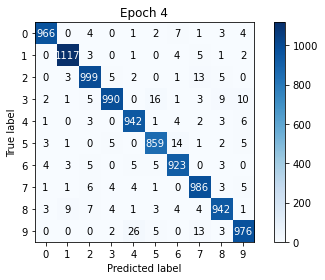

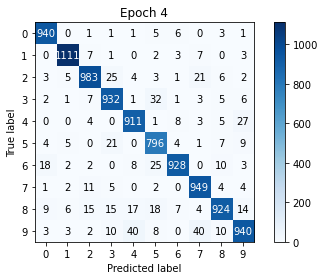

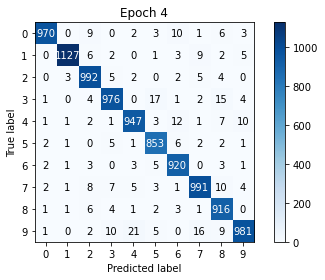

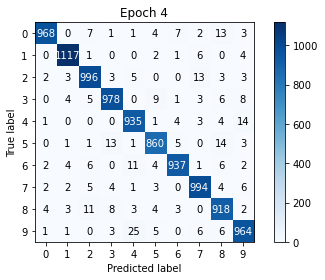

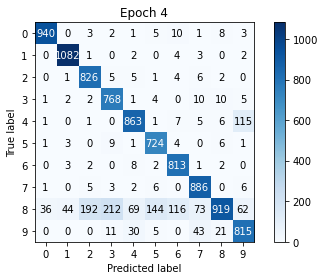

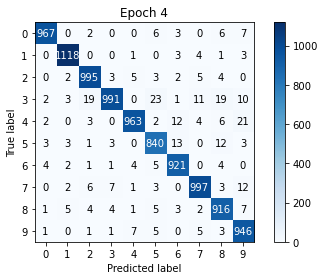

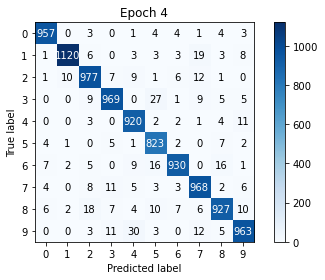

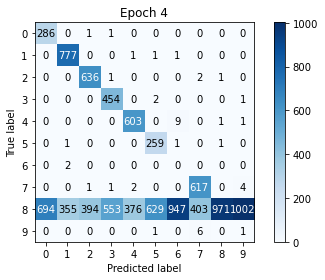

In [15]:
# Create and set experiment in ML Flow
# expt_id = mlflow.create_experiment('Fixed nH')

mlflow.set_experiment('Fixed nH')

# Doing for variety of choices of hyper-parameters
for lr in [0.01, 0.02, 0.05, 0.1]: # different values of learning rate
    for momentum in [0.9, 0.95, 0.99]: # different values of momentum
        for hidden_nodes in [48]: # different values of hidden nodes
        
            # for each combination of learning rate, momentum and hidden node
            # we are running one experiment

            # expt_id is a string concatenation of learning rate, momentum and hidden nodes       
            expt_id = '%d_%d_%d' % (int(lr*100), int(momentum*100), hidden_nodes)

            print('\nLR = %.2f, Momentum = %.2f, Hidden nodes = %d\n' % (lr, momentum, hidden_nodes))

            model = Model(hidden_nodes) # instantiate new model(because # hidden nodes varies)

            loss_fn = nn.CrossEntropyLoss()
            opt = optim.SGD(model.parameters(), lr=lr, momentum = momentum)

            # mlflow starts logging
            with mlflow.start_run() as run:
                # logging all the parameters in the args instance  
                for key, value in vars(args).items(): #logging args
                    mlflow.log_param(key, value)
                # logging the parameters    
                mlflow.log_param('lr', lr)
                mlflow.log_param('momentum', momentum)
                mlflow.log_param('hidden_nodes', hidden_nodes)

                for epoch in range(1, args.epochs + 1): # 4 epochs (mentioned previously)
                    # logging metrics including the confusion matrix (at last epoch)
                    # 4 epochs (so after each epoch metrics along with confusion matrix is logged)
                    train(epoch)
                    test(epoch)
                # logging the model at the last epoch
                mlflow.pytorch.log_model(model, "models")

# Loading and visualising a model

In [25]:
# Can do inference, training, transfer learning, visualization, etc (logging and loading models)

# loading the logged model
# model_load = mlflow.pytorch.load_model("models", run_id="037cd37def1347ae875b048a941a54ee")

model_path_dir = "models"
run_id = "037cd37def1347ae875b048a941a54ee"

model_load = mlflow.pytorch.load_model("runs:/" + run_id + "/" + model_path_dir)


In [26]:
print(model_load)

Model(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=10, bias=True)
  )
)


In [27]:
# How do the weights and bias looks like?
# layer 0's parameters (as data is in tensor we can convert into numpy)
weight_layer0 = list(model_load.parameters())[0].data.numpy()

In [28]:
print(weight_layer0.shape) # numpy array of the weights of the zeroth layer of the model

(48, 784)


[]

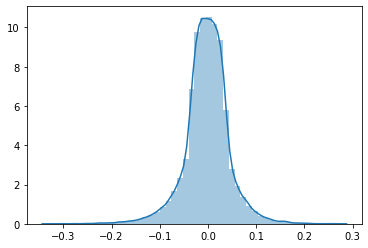

In [30]:
# plotting the distribution (histogram)
# it is good to see the plot if the weight distributed with the mean of zero (data is well normalized)
sns.distplot(weight_layer0.ravel())
plt.plot()

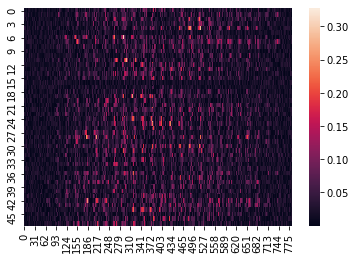

In [31]:
sns.heatmap(np.abs(weight_layer0))
plt.show()

In [32]:
# second layer
weight_layer1 = list(model_load.parameters())[2].data.numpy()

In [33]:
weight_layer1.shape

(10, 48)

[]

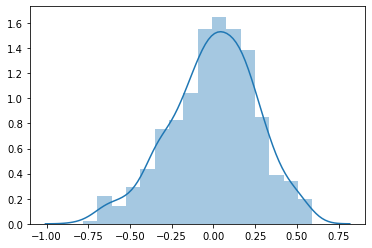

In [34]:
sns.distplot(weight_layer1.ravel())
plt.plot()

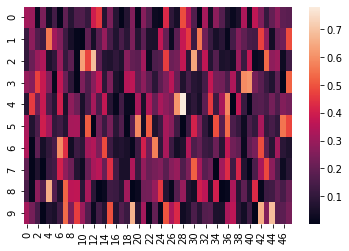

In [35]:
# high level mapping of input to output
# (pattern cannot be seen here because 48 features (784 is mapped on to 48)
# which means it is well normalized and so these 48 features are high level features
# corresponding to image (and then with no specific pattern these 48 features are
# classified to 10 classes)
sns.heatmap(np.abs(weight_layer1))
plt.show()

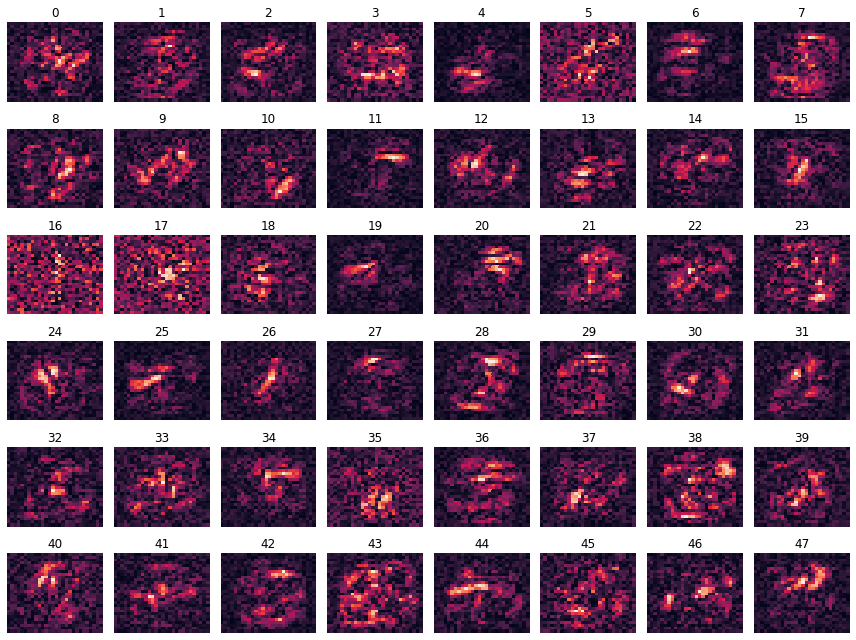

In [36]:
nrows = 6
ncols = 8
fig = plt.figure(figsize=(1.5*ncols, 1.5*nrows))

for i in np.arange(48): 
    ax1 = fig.add_subplot(nrows, ncols, i+1)
    sns.heatmap(np.abs((weight_layer0[i, 0:784]).reshape(28, 28)), ax = ax1, cbar=False)
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_title(i)
plt.tight_layout()
plt.show()